In [10]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=1
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib

import os
import numpy as np
from openTSNE import TSNE
from openTSNE.affinity import Affinities
import ncvis
import umap

import pickle
from sklearn.decomposition import PCA


import seaborn as sns

import scipy.sparse
from scipy.special import rel_entr
from vis_utils.loaders import load_pendigits
from vis_utils.utils import   KL_divergence, kNN_graph,  save_dict, load_dict,  joint_support, KL_divergence_sparse ,pythagorean_defect, sort_sims_by_proximity, acc_kNN
from vis_utils.plot import hists_from_graph_embd
from vis_utils.tsne_wrapper import TSNEwrapper
from vis_utils.plot import add_scale


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=1


In [2]:
root_path = "/export/ial-nfs/user/sdamrich/nce_data"
fig_path = "/export/ial-nfs/user/sdamrich/nce_data/figures"

In [3]:

# get data
x, y = load_pendigits(root_path)
a = 1.0
b = 1.0

n_epochs = 750
print(len(x))

k = 15
seed = 0
cmap = matplotlib.cm.get_cmap("tab10")


5620


In [4]:
file_name = os.path.join(root_path,
                         "pendigits",
                         f"sknn_graph_k_{k}_metric_euclidean.npz")
try:
    sknn_graph = scipy.sparse.load_npz(file_name)
except IOError:
    knn_graph = kNN_graph(x.astype("float"),
                          k,
                          metric="euclidean").cpu().numpy().flatten()
    knn_graph = scipy.sparse.coo_matrix((np.ones(len(x)*k),
                                         (np.repeat(np.arange(x.shape[0]), k),
                                          knn_graph)),
                                        shape=(len(x), len(x)))
    sknn_graph = knn_graph.maximum(knn_graph.transpose()).tocoo()

    scipy.sparse.save_npz(file_name, sknn_graph)


affinities = Affinities()
affinities.P = (sknn_graph / sknn_graph.sum()).tocsr()

In [5]:
# load / compute and save 2D PCA for initialisation
try:
    pca2 = np.load(os.path.join(root_path, "PCA2D.np"))
except FileNotFoundError:
    pca_projector = PCA(n_components = 2)
    pca2 = pca_projector.fit_transform(np.array(x))
    np.save(os.path.join(root_path, "PCA2D.npy"), pca2)

## tSNE

In [6]:
n_early_epochs = 0
perplexity = 2*k
rescale_tsne = True

if rescale_tsne:
    pca_tsne = pca2 / (np.std(pca2[:, 0] * 10000))
else:
    pca_tsne = pca2

In [7]:
log_kl = True
log_embds = True
file_name = os.path.join(root_path,
                         "pendigits",
                         f"tsne_bin_k_{k}_n_epochs_{n_epochs}_n_early_epochs_{n_early_epochs}_perplexity_{perplexity}_seed_{seed}_log_kl_{log_kl  }_log_embds_{log_embds}_init_pca_rescale_{rescale_tsne}.pkl")

In [8]:
try:
    tsne_data = load_dict(file_name)
except FileNotFoundError:
    tsne = TSNEwrapper(perplexity=perplexity,
                       metric="euclidean",
                       n_jobs=-1, # n_jobs=-10 does not work well, the cell does not print anything
                       random_state=seed,
                       verbose=True,
                       n_iter = n_epochs,
                       early_exaggeration_iter = n_early_epochs,
                       callbacks_every_iters=1,
                       log_kl=log_kl,
                       log_embds=log_embds,
                       initialization=pca_tsne)
    embd = tsne.fit_transform(x, affinities=affinities)

    # compute kl inv sq for tSNE

    tsne_kl_div_inv_sq = []
    for embd in tsne.aux_data["embds"]:
        tsne_kl_div_inv_sq.append(KL_divergence(sknn_graph,
                                                embedding=embd,
                                                a=a,
                                                b=b,
                                                norm_over_pos=False,
                                                sim_func="inv_sq"))

    tsne.aux_data["kl_div_inv_sq"] = tsne_kl_div_inv_sq

    save_dict(tsne.aux_data, file_name)
    tsne_data = tsne.aux_data

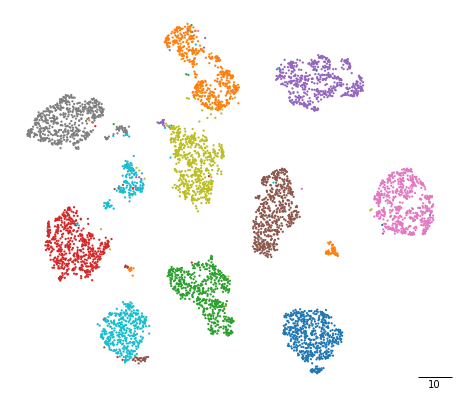

In [11]:
epoch = -1

plt.figure(figsize=(8,8))
plt.scatter(*tsne_data["embds"][epoch].T, c=y, s=20, marker=".", cmap="tab10", edgecolor="none", alpha=1.0)

plt.axis("off")
plt.gca().set_aspect("equal")
add_scale(plt.gca(), tsne_data["embds"][epoch])

plt.savefig(os.path.join(fig_path,
                         f"tsne_pendigits_bin_k_{k}_n_epochs_{n_epochs}_n_early_epochs_{n_early_epochs}_perplexity_{perplexity}_seed_{seed}_log_kl_{log_kl  }_log_embds_{log_embds}_init_pca_rescale_{rescale_tsne}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,
            dpi=300,
            transparent=False,
            facecolor='white')

In [18]:
tsne_data.keys()

dict_keys(['perplexity', 'metric', 'n_jobs', 'random_state', 'verbose', 'n_iter', 'early_exaggeration_iter', 'callbacks_every_iters', 'initialization', 'log_kl', 'errors', 'graph', 'embds', 'kl_div', 'kl_div_inv_sq'])

In [21]:
from vis_utils.utils import compute_normalization

tsne_norm = []
for embd in tsne_data["embds"]:
    norm = compute_normalization(embd, sim_func="cauchy", no_diag=True, a=1.0, b=1.0, eps=1e-4)
    tsne_norm.append(norm)

tensor([141663.1250], device='cuda:0')


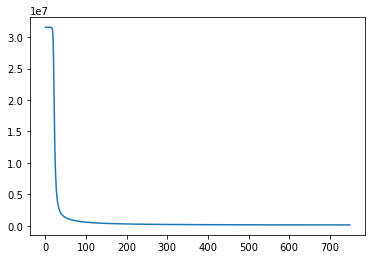

In [22]:
plt.plot(tsne_norm)
print(tsne_norm[-1])

## NCVis

In [12]:
# parameters for all methods

n_noise = 5
alpha_Q = 0.001
alpha = 1.0
rescale_ncvis = False
if rescale_ncvis:
    pca_ncvis = pca2 / (np.std(pca2[:, 0]) * 10000)
else:
    pca_ncvis = pca2


In [15]:

## No noise, no damped Q
fix_Q = False
noise_in_ratio = 0
file_name = os.path.join(root_path,
                         "pendigits",
                         f"ncvis_bin_k_{k}_n_epochs_{n_epochs}_fix_Q_{fix_Q}_noise_in_ratio_{noise_in_ratio}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}_a_{a}_b_{b}_init_pca_rescale_{rescale_ncvis}.pkl")

In [16]:
affinities = np.stack([sknn_graph.row, sknn_graph.col], axis=1)
try:
    ncvis_data = load_dict(file_name)
except FileNotFoundError:
    ncvisualizer = ncvis.NCVis(distance='correlation',
                               n_epochs=n_epochs,
                               a=a,
                               b=b,
                               random_seed=seed,
                               fix_Q=fix_Q,
                               noise_in_ratio=noise_in_ratio,
                               n_noise=n_noise,
                               alpha=alpha,
                               alpha_Q=alpha_Q)

    embd = ncvisualizer.fit_transform(x, affinities=affinities, init=pca_ncvis)

    ncvis_kl_div_inv_sq = []
    for embd in ncvisualizer.aux_data["embds"]:
        ncvis_kl_div_inv_sq.append(KL_divergence(sknn_graph,
                                                 embedding=embd,
                                                 a=a,
                                                 b=b,
                                                 norm_over_pos=False,
                                                 sim_func="inv_sq"))
    ncvisualizer.aux_data["kl_div_inv_sq"] = ncvis_kl_div_inv_sq

    save_dict(ncvisualizer.aux_data, file_name)
    ncvis_data = ncvisualizer.aux_data

157430.44
244967.12089444214
0.6426594594620629


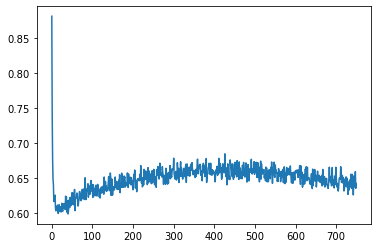

In [23]:
plt.plot(ncvis_data["normalization"][1:] / np.exp(ncvis_data["qs"][1:]))
print(ncvis_data["normalization"][-1] )
print(np.exp(ncvis_data["qs"][-1]))
print(ncvis_data["normalization"][-1]  / np.exp(ncvis_data["qs"][-1]))

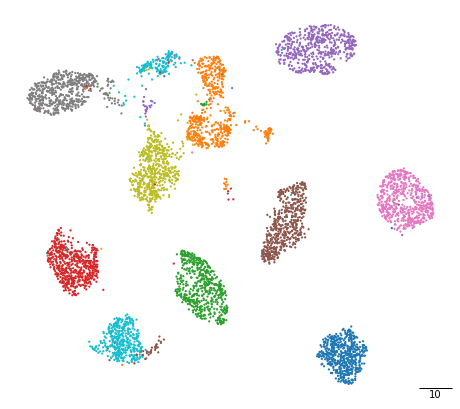

In [20]:
epoch = -1

plt.figure(figsize=(8,8))

plt.scatter(*ncvis_data["embds"][epoch].T, c=y, s=20, marker=".", cmap="tab10", edgecolor="none", alpha=1.0)

plt.axis("off")
plt.gca().set_aspect("equal")
add_scale(plt.gca(), ncvis_data["embds"][epoch])


plt.savefig(os.path.join(fig_path,
                         f"ncvis_pendigits_bin_k_{k}_n_epochs_{n_epochs}_fix_Q_{fix_Q}_noise_in_ratio_{noise_in_ratio}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}_a_{a}_b_{b}_init_pca_rescale_{rescale_ncvis}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,
            dpi=300,
            transparent=False,
            facecolor="white")

## UMAP

In [24]:
lr = 1.0
rescale_umap = False

if rescale_umap:
    pca_umap = pca2 / (np.std(pca2[:, 0]) * 10000)
else:
    pca_umap = pca2

In [25]:
filename = os.path.join(root_path, "pendigits", f"umap_bin_k_{k}_n_epochs_{n_epochs}_lr_{lr}_seed_{seed}_a_{a}_b_{b}_init_pca_rescaled_{rescale_umap}.pkl")
try:
    with open(filename, "rb") as file:
        umapper = pickle.load(file)
        embd_umap = umapper.embedding_
except FileNotFoundError:
    umapper = umap.UMAP(n_neighbors=15,
                        n_epochs=n_epochs,
                        log_losses="after",
                        a=a,
                        b=b,
                        log_embeddings=True,
                        log_norm=True,
                        log_kl=True,
                        random_state=seed,
                        verbose=True,
                        init=pca_umap,
                        graph=sknn_graph,
                        learning_rate=lr)
    embd = umapper.fit_transform(x)
    with open(filename, "wb") as file:
        pickle.dump(umapper, file, pickle.HIGHEST_PROTOCOL)

UMAP(a=1.0, b=1.0, dens_frac=0.0, dens_lambda=0.0,
     init=array([[  8.12602639, -10.53128499],
       [ -2.95753082,  16.45795556],
       [  1.37667094,   9.68405511],
       ...,
       [ 24.69394275,  -0.65816687],
       [ 26.96221944, -11.37959012],
       [-19.55782494,  16.8972358 ]]),
     log_embeddings=True, log_kl=True, log_losses='after', log_norm=True,
     n_epochs=750, random_state=0, verbose=True)
Construct fuzzy simplicial set
Fri Feb 11 11:52:40 2022 Construct embedding


/export/data/sdamrich/anaconda3/envs/nce/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


	completed  0  /  750 epochs
	completed  75  /  750 epochs
	completed  150  /  750 epochs
	completed  225  /  750 epochs
	completed  300  /  750 epochs
	completed  375  /  750 epochs
	completed  450  /  750 epochs
	completed  525  /  750 epochs
	completed  600  /  750 epochs
	completed  675  /  750 epochs
Fri Feb 11 11:55:32 2022 Finished embedding


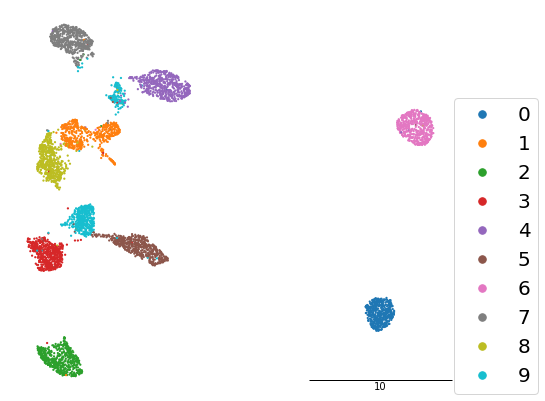

In [26]:
epoch=-1
plt.figure(figsize=(8,8))
plt.scatter(*umapper.aux_data["embeddings"][epoch].T, c=y, s=20, marker=".", cmap="tab10", edgecolor="none", alpha=1.0)

plt.axis("off")
plt.gca().set_aspect("equal")
add_scale(plt.gca(), umapper.aux_data["embeddings"][epoch])


# dummy dots for legend
dots = []
for i in range(len(np.unique(y))):
    dot = mlines.Line2D([], [], color=cmap(i), marker='.', linestyle="none", markersize=15, label=np.unique(y)[i])
    dots.append(dot)

plt.legend(handles=dots, prop={'size': 20}, loc=(1,0))

plt.savefig(os.path.join(fig_path,
                         f"umap_pendigits_bin_k_{k}_n_epochs_{n_epochs}_lr_{lr}_seed_{seed}_a_{a}_b_{b}_init_pca_rescaled_{rescale_umap}_legend.png"),
            bbox_inches = 'tight',
            pad_inches = 0,
            dpi=300,
            transparent=False,
            facecolor="white")

In [148]:
lr = 0.01
rescale_umap = True

if rescale_umap:
    pca_umap = pca2 / (np.std(pca2[:, 0]) * 10000)
else:
    pca_umap = pca2

In [149]:
filename = os.path.join(root_path, "pendigits", f"umap_bin_k_{k}_n_epochs_{n_epochs}_lr_{lr}_seed_{seed}_a_{a}_b_{b}_init_pca_rescaled_{rescale_umap}.pkl")
try:
    with open(filename, "rb") as file:
        umapper_low = pickle.load(file)
except FileNotFoundError:
    umapper_low = umap.UMAP(n_neighbors=15,
                        n_epochs=n_epochs,
                        log_losses="after",
                        a=a,
                        b=b,
                        log_embeddings=True,
                        log_norm=True,
                        log_kl=True,
                        random_state=seed,
                        verbose=True,
                        init=pca_umap,
                        graph=sknn_graph,
                        learning_rate=lr)
    _ = umapper_low.fit_transform(x)
    with open(filename, "wb") as file:
        pickle.dump(umapper, file, pickle.HIGHEST_PROTOCOL)

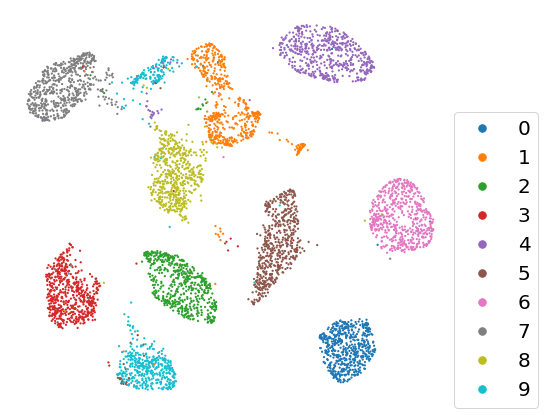

In [150]:
epoch=-1
plt.figure(figsize=(8,8))
plt.scatter(*umapper_low.aux_data["embeddings"][epoch].T, c=y, s=20, marker=".", cmap="tab10", edgecolor="none", alpha=1.0)

plt.axis("off")
plt.gca().set_aspect("equal")

# dummy dots for legend
dots = []
for i in range(len(np.unique(y))):
    dot = mlines.Line2D([], [], color=cmap(i), marker='.', linestyle="none", markersize=15, label=np.unique(y)[i])
    dots.append(dot)

plt.legend(handles=dots, prop={'size': 20}, loc=(1,0))

plt.savefig(os.path.join(fig_path,
                         f"umap_pendigits_bin_k_{k}_n_epochs_{n_epochs}_lr_{lr}_seed_{seed}_a_{a}_b_{b}_init_pca_rescaled_{rescale_umap}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,
            dpi=300)

# KL comparison

In [120]:
plt.rcParams['font.size'] = 15


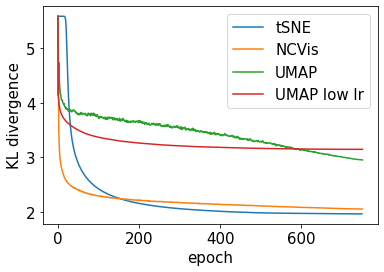

In [126]:
# using chauchy similarity
plt.figure()
plt.plot(tsne_data["kl_div"], label="tSNE")
plt.plot(ncvis_data["kl_div"], label="NCVis")
plt.plot([ncvis_data["kl_div"][0]] + list(umapper.aux_data["kl_cauchy"]), label="UMAP")
plt.plot([ncvis_data["kl_div"][0]] + list(umapper_low.aux_data["kl_cauchy"]), label="UMAP low lr")
plt.ylabel("KL divergence")
plt.xlabel("epoch")
plt.legend()
plt.savefig(os.path.join(fig_path,
                         f"KL_divs_cauchy_pen_digits_n_epochs_{n_epochs}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,
            dpi=300)

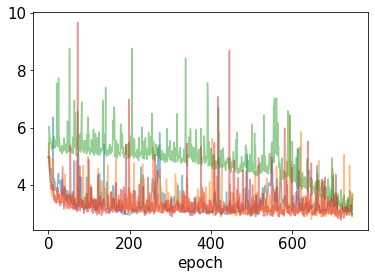

In [127]:
 #plot
plt.figure()
plt.plot(tsne_data["kl_div_inv_sq"], alpha=0.5, label="tSNE")
plt.plot(ncvis_data["kl_div_inv_sq"], alpha=0.5, label="NCVis")
plt.plot([ncvis_data["kl_div_inv_sq"][0]] + list(umapper.aux_data["kl_inv_sq"]), alpha=0.5, label="UMAP")
plt.plot([ncvis_data["kl_div_inv_sq"][0]] + list(umapper_low.aux_data["kl_inv_sq"]), alpha=0.5, label="UMAP low lr")

#plt.ylabel("KL divergence")
plt.xlabel("epoch")
#plt.legend()

plt.savefig(os.path.join(fig_path,
                         f"KL_divs_inv_sq_pen_digits_n_epochs_{n_epochs}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,
            dpi=300)

In [128]:
def smooth(scalars, weight):
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

In [129]:
smooth_weight = 0.95

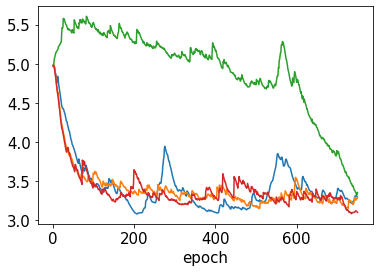

In [130]:
tsne_kl_div_inv_sq_smooth = smooth(list(tsne_data["kl_div_inv_sq"]), smooth_weight)
ncvis_kl_div_inv_sq_smooth = smooth(list(ncvis_data["kl_div_inv_sq"]), smooth_weight)
umap_kl_div_inv_sq_smooth = smooth([ncvis_data["kl_div_inv_sq"][0]] + list(umapper.aux_data["kl_inv_sq"]), smooth_weight)
umap_low_kl_div_inv_sq_smooth = smooth([ncvis_data["kl_div_inv_sq"][0]] + list(umapper_low.aux_data["kl_inv_sq"]), smooth_weight)


plt.plot(tsne_kl_div_inv_sq_smooth, alpha=1.0, label="tSNE")
plt.plot(ncvis_kl_div_inv_sq_smooth, alpha=1.0, label="NCVis")
plt.plot(umap_kl_div_inv_sq_smooth, alpha=1.0, label="UMAP")
plt.plot(umap_low_kl_div_inv_sq_smooth, alpha=1.0, label="UMAP low lr")

#plt.ylabel("KL divergence")
plt.xlabel("epoch")
#plt.legend()
plt.savefig(os.path.join(fig_path,
                         f"KL_divs_inv_sq_smooth_pen_digits_n_epochs_{n_epochs}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,
            dpi=300)

In [50]:
from vis_utils.utils import KL_divergence, compute_normalization, compute_inv_square_psim_keops_embd

In [76]:
eps = 1e-10 #float(np.finfo(float).eps)

In [77]:
KL_divergence(sknn_graph, umapper.aux_data["embeddings"][-1], sim_func="inv_sq", eps=eps)

2.9809997768346577

In [78]:
KL_divergence(sknn_graph, tsne_data["embds"][-1], sim_func="inv_sq", eps=eps)

3.144730383075755

In [79]:
KL_divergence(sknn_graph, ncvis_data["embds"][-1], sim_func="inv_sq", eps=eps)

3.498214591197792

In [ ]:
type(np.finfo(float).eps)

In [32]:
type(np.finfo(float).eps)

numpy.float64

In [36]:
type(float(np.finfo(float).eps)**2)

float

In [124]:
embedding = tsne_data["embds"][-1] #ncvis_data["embds"][-1] #umapper.aux_data["embeddings"][-1]
heads = sknn_graph.row
tails = sknn_graph.col

# compute low dimensional simiarities on the edges with positive p_ij
sq_dist_pos_edges = ((embedding[heads]-embedding[tails])**2).sum(-1)

In [125]:
sq_dist_pos_edges.min()

1.6168952694622388e-05

In [126]:
sq_dist_edges = ((embedding[:, None]-embedding[None, :])**2).sum(-1)
ind = np.triu_indices(len(sq_dist_edges), k=1)
sq_dists_edges = sq_dist_edges[ind]
print(sq_dists_edges.min())

1.6168952694622388e-05


In [73]:
from vis_utils.utils import inv_square_sim_dist, compute_normalization

In [63]:
eps =  1e-4 #float(np.finfo(float).eps)


In [64]:
norm_pos = inv_square_sim_dist(sq_dist_pos_edges, squared=True, eps = eps).sum()
norm_pos

12664547.0

In [68]:
norm_pos = inv_square_sim_dist(sq_dist_pos_edges, squared=True, eps = 1e-18).sum()
norm_pos

12671270.0

In [65]:
norm = inv_square_sim_dist(sq_dists_edges, squared=True, eps = eps).sum()
norm

13344973.0

In [98]:
norm_via_keops = compute_normalization(embedding, sim_func="inv_sq", no_diag=True, eps =1e-8)

In [83]:
norm / norm_via_keops.cpu().numpy()

array([11.593996], dtype=float32)

In [95]:
norm_with_diag = inv_square_sim_dist(((embedding[:, None]-embedding[None, :])**2).sum(-1), squared=True, eps=1e-8).sum()

In [92]:
norm_via_keops_with_diag = compute_normalization(embedding, sim_func="inv_sq", no_diag=False, eps =1e-8)

In [93]:
norm_via_keops

tensor([5.6200e+11], device='cuda:0')

In [97]:
norm_with_diag - 5620 * 10**8

575504.5457763672

In [99]:
norm_via_keops

tensor([575504.4375], device='cuda:0')

In [101]:
norm_pos = inv_square_sim_dist(sq_dist_pos_edges, squared=True, eps = 1e-18).sum()
norm_pos*2

573778.641478202

In [105]:
norm = inv_square_sim_dist(sq_dists_edges, squared=True, eps = 1e-8).sum()
norm * 2

575504.5454578194

In [135]:
ncvis_data["kl_div"][0]

3.9385777144651737

In [136]:
tsne_data["kl_div"][0]

5.587202864112534

In [137]:
umapper.aux_data["kl_cauchy"][0]

4.132438104219441